In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import IPython
import seedir as sd

import librosa
from pydub import AudioSegment
from pydub.silence import split_on_silence
from scipy.io.wavfile import read

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

## Feature extraction

- additional/: additional files created during the work of the algorithm
- data/train/: 10 folders each with ~100 records of the corresponding digit
- data/test/: 300 records of "telephone number" (a  record containing 10 digits)
- output/: contains the predictions for 300 "telephone numbers"

In [5]:
sd.seedir(style='emoji', itemlimit=10, beyond='ellipsis')

📁 Audio recognition/
├─📁 .ipynb_checkpoints/
│ └─📄 AudioRecognition-checkpoint.ipynb
├─📁 additional/
│ ├─📄 df_features_test.csv
│ ├─📄 df_number_of_segments.csv
│ ├─📄 df_train_features.csv
│ └─📁 tmp/
│   ├─📄 phone_number_0.wav
│   ├─📄 phone_number_1.wav
│   ├─📄 phone_number_2.wav
│   ├─📄 phone_number_3.wav
│   ├─📄 phone_number_4.wav
│   ├─📄 phone_number_5.wav
│   ├─📄 phone_number_6.wav
│   ├─📄 phone_number_7.wav
│   ├─📄 phone_number_8.wav
│   └─📄 phone_number_9.wav
├─📄 AudioRecognition.ipynb
├─📁 data/
│ ├─📁 test/
│ │ ├─📄 0.wav
│ │ ├─📄 1.wav
│ │ ├─📄 10.wav
│ │ ├─📄 100.wav
│ │ ├─📄 101.wav
│ │ ├─📄 102.wav
│ │ ├─📄 103.wav
│ │ ├─📄 104.wav
│ │ ├─📄 105.wav
│ │ ├─📄 106.wav
│ │ └─📄 ...
│ └─📁 train/
│   └─📁 digits/
│     ├─📁 num0/
│     │ ├─📄 0_phone_0.wav
│     │ ├─📄 10_phone_0.wav
│     │ ├─📄 11_phone_0.wav
│     │ ├─📄 12_phone_0.wav
│     │ ├─📄 13_phone_0.wav
│     │ ├─📄 14_phone_0.wav
│     │ ├─📄 15_phone_0.wav
│     │ ├─📄 16_phone_0.wav
│     │ ├─📄 17_phone_0.wav
│     │ ├─📄 18_phone_0.wav
│

In [7]:
def plot_record(path_audio, title_string):
    """
        Plots the amplitude of the wav file from <path_audio> in axis Time-Amplitude with the title <title_string>
    """
    
    audio = read(path_audio)[1]
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(audio)
    ax.set_title(title_string, size=14)
    ax.set_ylabel("Amplitude", size=12)
    ax.set_xlabel("Time", size=12)
    ax.set_xticklabels([])
    ax.set_yticklabels([]);

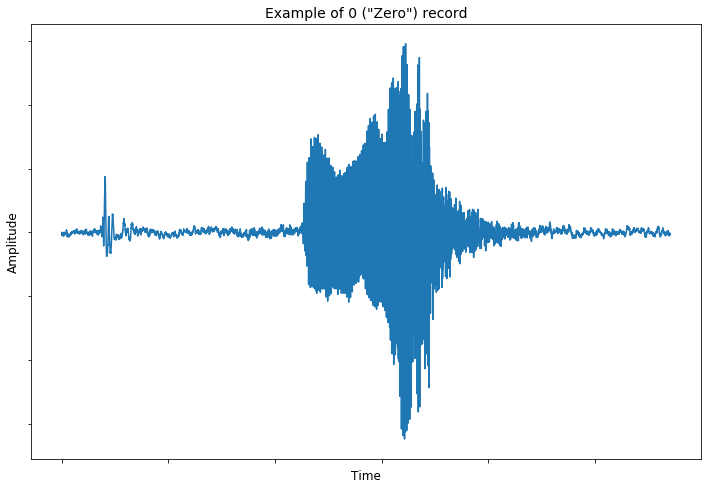

In [8]:
# we take a look at the first audio file in the 0 folder

path_audio_train_sample = 'data/train/digits/num0/0_phone_0.wav'
plot_record(path_audio_train_sample, 'Example of 0 ("Zero") record')

In [62]:
# here we can listen to the same record

IPython.display.Audio(path_audio_train_sample)

In [9]:
digits = '0 1 2 3 4 5 6 7 8 9'.split()

# DataFrame to count the number of files in each data/train/num{} folder
df_digits_count = pd.DataFrame(index=digits, columns=['Number of files'])

# DataFrame containing the extracted features 
df_features = pd.DataFrame(columns=['chroma_stft', 
                                    'rmse', 
                                    'spectral_centroid', 
                                    'spectral_bandwidth', 
                                    'rolloff', 
                                    'zero_crossing_rate'] +\
                                   [f'mfcc{i}' for i in range(1, 21)] +\
                                   ['label'])

for n in digits:
    df_digits_count.at[n, ['Number of files']] = len(os.listdir(f'data/train/digits/num{n}'))
    
    for filename in os.listdir(f'data/train/digits/num{n}'):
        path_audio = f'data/train/digits/num{n}/{filename}'
        y, sr = librosa.load(path_audio)
        
        # extraction of features from the audio files
        rmse = librosa.feature.rms(y=y)[0]
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) 
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        
        df_features.loc[len(df_features)] = [np.mean(chroma_stft),
                                             np.mean(rmse),
                                             np.mean(spec_cent),
                                             np.mean(spec_bw),
                                             np.mean(rolloff),
                                             np.mean(zcr)] +\
                                            [np.mean(_) for _ in mfcc] +\
                                            [n]
        df_features.to_csv('additional/df_train_features.csv', index=None)

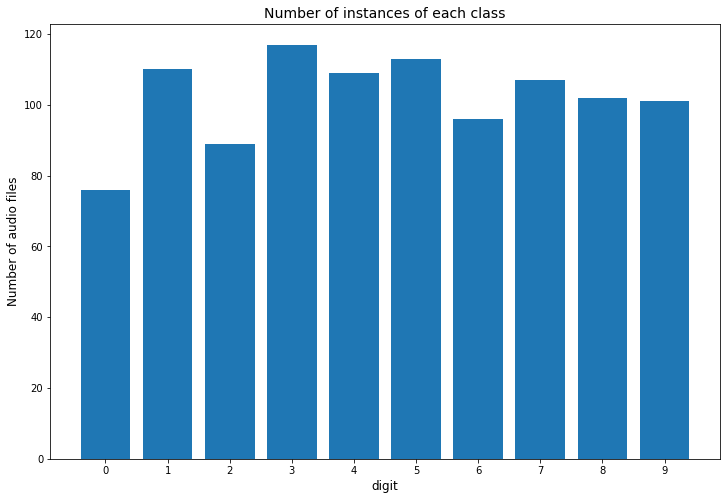

In [10]:
# make sure that the classes are balanced

plt.rcParams["figure.figsize"] = (12,8)
plt.bar(df_digits_count.index, df_digits_count['Number of files']);
plt.title('Number of instances of each class', size=14)
plt.xlabel('digit', size=12)
plt.ylabel('Number of audio files', size=12);

In [11]:
# prepare the data to feed into the DNN

data = pd.read_csv('additional/df_train_features.csv')
data = data.sample(frac=1).reset_index(drop=True)

labels_list = np.array(data.iloc[:, -1]).reshape(-1, 1)
encoder = OneHotEncoder()
y = encoder.fit_transform(labels_list).toarray()

scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [12]:
X[0]

array([ 0.61237564, -0.68823875, -0.4679822 ,  0.15590028, -0.63731776,
       -0.48660091, -0.6353711 ,  0.45543137,  0.75885344,  0.38263407,
       -0.17116781, -0.69258144, -0.5854319 ,  1.28366372,  1.52157138,
       -0.08107546, -0.61670438, -0.24038349,  0.05502974,  0.59556693,
        1.47395448,  0.8436057 ,  0.59639132,  1.33546301,  0.78797158,
       -0.61087981])

In [13]:
y[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

## Model training

In [14]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(X.shape[1],)),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               13824     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

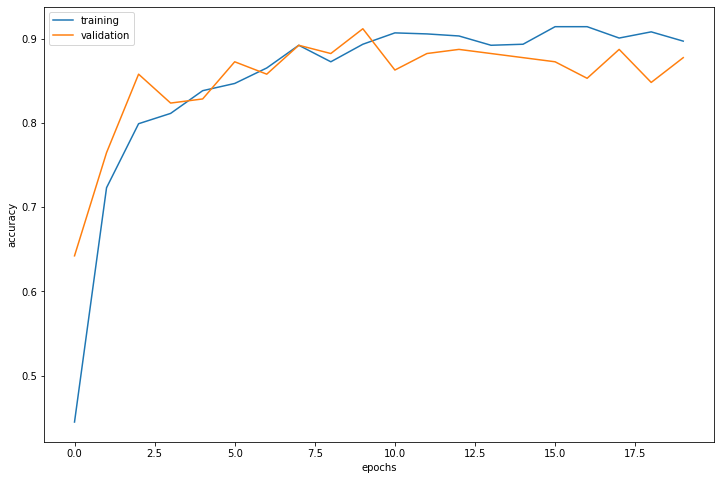

In [15]:
history = model.fit(X,y,
                    epochs=20, verbose=False,
                    validation_split=0.2)

plt.plot(history.epoch, history.history['accuracy'], label='training')
plt.plot(history.epoch, history.history['val_accuracy'], label='validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend();

## Splitting the "telephone numbers" into digits

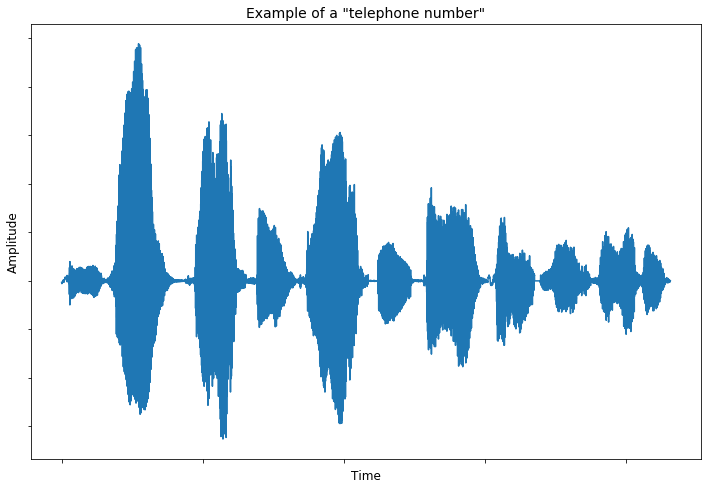

In [16]:
# take a look at the first audio file ('telephone number') in data/test/ folder

path_audio_test_sample = 'data/test/0.wav'
plot_record(path_audio_test_sample, 'Example of a "telephone number"')

In [17]:
# listen to the same record

IPython.display.Audio(path_audio_test_sample)

- In order to split 'telephone numbers' into separated digits, *split_on_silence* function from *pydub.silence* is used  
- It splits the 'telephone numbers' into a number of segments, though this number may differ from 10 - depending on the parameteres  
- A simple grid search is applied to find out the best parameteres for it  
- As the procedure is quite long the results were saved in *additional/df_number_of_segments.csv*

In [21]:
# min_silence_len_range = range(105, 116)
# silence_thresh_range = range(-40, -29)

# # DataFrame containing the number of segments 
# df_number_of_segments = pd.DataFrame(data=0,\
#                                      index=pd.MultiIndex.from_product([min_silence_len_range, silence_thresh_range],\
#                                      names=['min_silence_len_range', 'silence_thresh_range']),\
#                                      columns=range(1, 21))

# for min_silence_len in min_silence_len_range:
#     for silence_thresh in silence_thresh_range:
        
#         number_of_segments = []
        
#         for filename in sorted(os.listdir(f'data/test/'), key=lambda x: int(x[:-4])):
#             sound_file = AudioSegment.from_wav(f'data/test/{filename}')
#             audio_fragments = split_on_silence(sound_file, min_silence_len=min_silence_len, silence_thresh=silence_thresh)
#             if len(audio_fragments) > 10:
#                 audio_fragments = [audio_fragments[i] for i in range(len(audio_fragments))\
#                                    if audio_fragments[i].duration_seconds > 0.25]
#             number_of_segments.append(len(audio_fragments))
        
#         values, counts = np.unique(number_of_segments, return_counts=True)
#         for v, c in zip(values, counts):
#             df_number_of_segments.loc[(min_silence_len, silence_thresh)][v] = c  
            
#         df_number_of_segments.to_csv('additional/df_number_of_segments.csv')

df_number_of_segments = pd.read_csv('additional/df_number_of_segments.csv',\
                                    index_col=['min_silence_len_range', 'silence_thresh_range'])

In [22]:
df_number_of_segments

1  2  3  4  5  6   7   8    9  \
min_silence_len_range silence_thresh_range                                  
105                   -40                   0  0  0  0  0  2   8  24  104   
                      -39                   0  0  0  0  0  0   0   6   62   
                      -38                   0  0  0  0  0  0   0   3   31   
                      -37                   0  0  0  0  0  0   0   4    9   
                      -36                   0  0  0  0  0  0   0   4    6   
...                                        .. .. .. .. .. ..  ..  ..  ...   
115                   -34                   0  0  0  0  0  0   0   6   21   
                      -33                   0  0  0  0  0  0   0   7   35   
                      -32                   0  0  0  0  0  0   2  23   72   
                      -31                   0  0  0  0  0  0   8  27   90   
                      -30                   0  0  0  0  0  3  13  38   95   

                                             10  11  12  13  14  15  16  17  \
min_silence_len_range silence_thresh_range                                    
105                   -40                   130  25   7   0   0   0   0   0   
                      -39                   206  19   5   2   0   0   0   0   
                      -38                   226  30   7   3   0   0   0   0   
                      -37                   264  19   4   0   0   0   0   0   
                      -36                   284   6   0   0   0   0   0   0   
...                                         ...  ..  ..  ..  ..  ..  ..  ..   
115                   -34                   269   4   0   0   0   0   0   0   
                      -33                   245  13   0   0   0   0   0   0   
                      -32                   193  10   0   0   0   0   0   0   
                      -31                   173   2   0   0   0   0   0   0   
                      -30                   148   3   0   0   0   0   0   0   

                                            18  19  20  
min_silence_len_range silence_thresh_range              
105                   -40                    0   0   0  
                      -39                    0   0   0  
                      -38                    0   0   0  
                      -37                    0   0   0  
                      -36                    0   0   0  
...                                         ..  ..  ..  
115                   -34                    0   0   0  
                      -33                    0   0   0  
                      -32                    0   0   0  
                      -31                    0   0   0  
                      -30                    0   0   0  

[121 rows x 20 columns]

In [24]:
df_number_of_segments[df_number_of_segments['10'] == df_number_of_segments['10'].max()]

1  2  3  4  5  6  7  8   9   10  \
min_silence_len_range silence_thresh_range                                    
105                   -36                   0  0  0  0  0  0  0  4   6  284   
                      -35                   0  0  0  0  0  0  0  0  14  284   
106                   -36                   0  0  0  0  0  0  0  4   6  284   
                      -35                   0  0  0  0  0  0  0  0  14  284   
109                   -36                   0  0  0  0  0  0  0  4   6  284   
110                   -36                   0  0  0  0  0  0  0  4   6  284   
111                   -36                   0  0  0  0  0  0  0  4   6  284   
112                   -36                   0  0  0  0  0  0  0  4   5  284   

                                            11  12  13  14  15  16  17  18  \
min_silence_len_range silence_thresh_range                                   
105                   -36                    6   0   0   0   0   0   0   0   
                      -35                    2   0   0   0   0   0   0   0   
106                   -36                    6   0   0   0   0   0   0   0   
                      -35                    2   0   0   0   0   0   0   0   
109                   -36                    6   0   0   0   0   0   0   0   
110                   -36                    6   0   0   0   0   0   0   0   
111                   -36                    6   0   0   0   0   0   0   0   
112                   -36                    7   0   0   0   0   0   0   0   

                                            19  20  
min_silence_len_range silence_thresh_range          
105                   -36                    0   0  
                      -35                    0   0  
106                   -36                    0   0  
                      -35                    0   0  
109                   -36                    0   0  
110                   -36                    0   0  
111                   -36                    0   0  
112                   -36                    0   0

- We can see several combinations of (min_silence_len_range, silence_thresh_range) parameteres which lead to the maximum number of "telephone numbers" that are splitted into 10 fragments  
- Let us pick (110, -36)
- There are several ways to handle other 16 files which are not splitted into 10 fragments
- We would listen to them and manually pick relevant fragments (in cases where number of fragments is more than 10) or concatenate sseveral fragments into one (in cases where number of fragments if less than 10)

In [25]:
# files which were not splitted into 10 fragments
files_num_fragments_ne10 = []

for filename in sorted(os.listdir(f'data/test/'), key=lambda x: int(x[:-4])):
    sound_file = AudioSegment.from_wav(f'data/test/{filename}')
    audio_fragments = split_on_silence(sound_file, min_silence_len=110, silence_thresh=-36)
    if len(audio_fragments) > 10:
        audio_fragments = [audio_fragments[i] for i in range(len(audio_fragments))\
                           if audio_fragments[i].duration_seconds > 0.25]
    if len(audio_fragments) != 10:
        files_num_fragments_ne10.append(filename)

In [27]:
files_num_fragments_ne10

['4.wav',
 '15.wav',
 '23.wav',
 '37.wav',
 '65.wav',
 '77.wav',
 '111.wav',
 '133.wav',
 '137.wav',
 '152.wav',
 '163.wav',
 '233.wav',
 '239.wav',
 '266.wav',
 '280.wav',
 '287.wav']

In [74]:
# DataFrame containing the extracted features 
df_features_test = pd.DataFrame(columns=['chroma_stft', 
                                         'rmse', 
                                         'spectral_centroid', 
                                         'spectral_bandwidth', 
                                         'rolloff', 
                                         'zero_crossing_rate'] +\
                                        [f'mfcc{i}' for i in range(1, 21)])

for filename in sorted(os.listdir(f'data/test/'), key=lambda x: int(x[:-4])):
    sound_file = AudioSegment.from_wav(f'data/test/{filename}')
    audio_fragments = split_on_silence(sound_file, min_silence_len=110, silence_thresh=-36)
    
    # manually splitting 16 files into 10 fragments
    if filename == '4.wav':
        audio_fragments = [audio_fragments[i] for i in range(len(audio_fragments)) if (i != 0 and i != 3)]
    elif filename == '15.wav':
        audio_fragments = [audio_fragments[i] for i in range(len(audio_fragments)) if (i != 2 and i != 6)]
    elif filename == '23.wav':
        audio_fragments = [audio_fragments[0], audio_fragments[1], audio_fragments[2], audio_fragments[3],
                        audio_fragments[4] + audio_fragments[5], audio_fragments[6], audio_fragments[7], 
                        audio_fragments[8], audio_fragments[9], audio_fragments[10]]
    elif filename == '37.wav':
        audio_fragments = [audio_fragments[i] for i in range(len(audio_fragments)) if (i != 1)]
    elif filename == '65.wav':  
        audio_fragments = [audio_fragments[0], audio_fragments[1], audio_fragments[2], audio_fragments[3],
                        audio_fragments[4] + audio_fragments[5], audio_fragments[6], audio_fragments[7], 
                        audio_fragments[8], audio_fragments[9], audio_fragments[10]]   
    elif filename == '77.wav':
        audio_fragments = [audio_fragments[0], audio_fragments[1], audio_fragments[2], audio_fragments[3],
                        audio_fragments[4], audio_fragments[5], audio_fragments[6], audio_fragments[7], 
                        audio_fragments[8] + audio_fragments[9], audio_fragments[10]]
    elif filename == '111.wav':     
        audio_fragments = [audio_fragments[i] for i in range(len(audio_fragments)) if (i != 3 and i!= 4)]
    elif filename == '133.wav':     
        audio_fragments = [audio_fragments[0], audio_fragments[1], audio_fragments[2], audio_fragments[3] +
                        audio_fragments[4], audio_fragments[5], audio_fragments[6] + audio_fragments[7], 
                        audio_fragments[8], audio_fragments[9], audio_fragments[10], audio_fragments[11]]
    elif filename == '137.wav':     
        audio_fragments = [audio_fragments[0], audio_fragments[1], audio_fragments[2], audio_fragments[3],
                        audio_fragments[4], audio_fragments[5], audio_fragments[6], audio_fragments[7], 
                        audio_fragments[8], audio_fragments[9] + audio_fragments[10]]
    elif filename == '152.wav':
        audio_fragments = [audio_fragments[i] for i in range(len(audio_fragments)) if (i != 4)]
    elif filename == '163.wav':  
        audio_fragments = [audio_fragments[i] for i in range(len(audio_fragments)) if (i != 6 and i != 7)]  
    elif filename == '233.wav': 
        audio_fragments = split_on_silence(sound_file, min_silence_len=90, silence_thresh=-36)    
    elif filename == '239.wav':
        audio_fragments = [audio_fragments[i] for i in range(len(audio_fragments)) if (i != 2)]    
    elif filename == '266.wav':
        audio_fragments = [audio_fragments[i] for i in range(len(audio_fragments)) if (i != 2)]    
    elif filename == '280.wav':    
        audio_fragments = [audio_fragments[0], audio_fragments[1], audio_fragments[2], audio_fragments[3],
                        audio_fragments[4], audio_fragments[5], audio_fragments[6], audio_fragments[7] + 
                        audio_fragments[8], audio_fragments[9], audio_fragments[10]]
    elif filename == '287.wav':    
        audio_fragments = [audio_fragments[0], audio_fragments[1] + audio_fragments[2], audio_fragments[3],
                        audio_fragments[4], audio_fragments[5], audio_fragments[6], audio_fragments[7], 
                        audio_fragments[8], audio_fragments[9], audio_fragments[10]]
        
    elif len(audio_fragments) > 10:
        audio_fragments = [audio_fragments[i] for i in range(len(audio_fragments)) if audio_fragments[i].duration_seconds > 0.25]
    
    # write 10 fragments to .wav files to extract features from them
    for i in range(len(audio_fragments)):
        audio_fragments[i].export(f'additional/tmp/phone_number_{i}.wav', format='wav')
    
    for i in range(len(audio_fragments)):
        audio = f'additional/tmp/phone_number_{i}.wav'
        y, sr = librosa.load(audio)
        
        # extraction of features from the audio files
        rmse = librosa.feature.rms(y=y)[0]
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        
        df_features_test.loc[len(df_features_test)] = [np.mean(chroma_stft),
                                                       np.mean(rmse),
                                                       np.mean(spec_cent),
                                                       np.mean(spec_bw),
                                                       np.mean(rolloff),
                                                       np.mean(zcr)] +\
                                                      [np.mean(_) for _ in mfcc]
        
        df_features_test.to_csv('additional/df_features_test.csv', index=None)        

In [30]:
# prepare the data to feed into the DNN
data_test = pd.read_csv('additional/df_features_test.csv')

scaler = StandardScaler()
X_test = scaler.fit_transform(np.array(data_test, dtype = float))

pred = model.predict(X_test)

# extract the predicted digits
pred_labels = np.zeros(shape=(3000,), dtype=int)
for i in range(pred.shape[0]):
    pred_labels[i] = np.argmax(pred[i])
    
pred_numbers = pd.Series(index=range(300), dtype='str')

for i in range(300):
    pred_numbers[i] = ''.join(str(pred_labels[i*10:(i+1)*10]))[1:-1].replace(' ', '')

# DataFrame containing predictions in the required format for the evaluating system
df_res = pd.DataFrame(index=range(300), data=pred_numbers, columns=['Phone'])
df_res.to_csv('output/Predictions.csv', columns=['Phone'], header=False)

In [31]:
df_res

,Phone
0,8444385511
1,6724714074
2,3768793761
3,0491586467
4,4504533498
...,...
295,9354000793
296,0602014227
297,6631434296
298,3854566764


In [92]:
# here we can listen to the 0th 'telephone number'
# it seems only the last (10th) digit is incorrect: we predicted 1 instead of 7
# everything else is right!

IPython.display.Audio(path_audio_test_sample)